In [1]:
import pandas as pd 
import sys 

sys.path.append('../../')
import helpers.data_helpers as data_helpers
import datetime
import pytz
import numpy as np 
import matplotlib.pyplot as plt
import backtesting 
from backtesting import Backtest, Strategy 

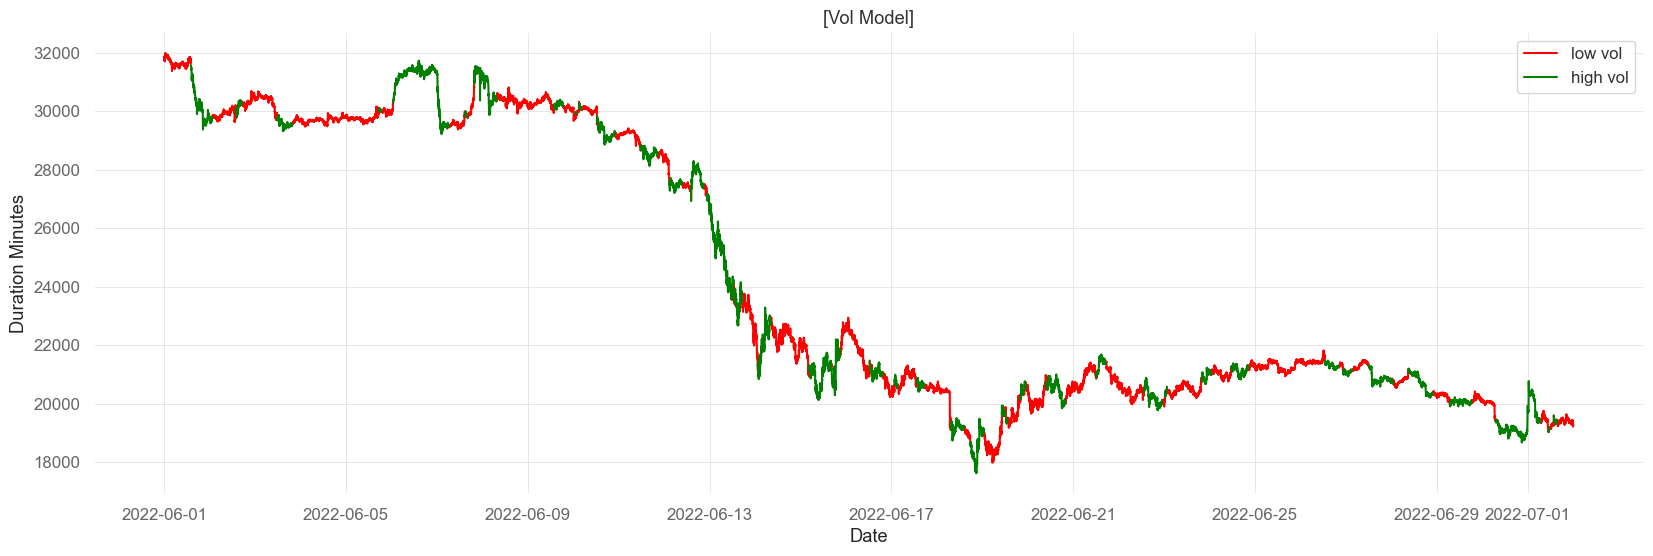

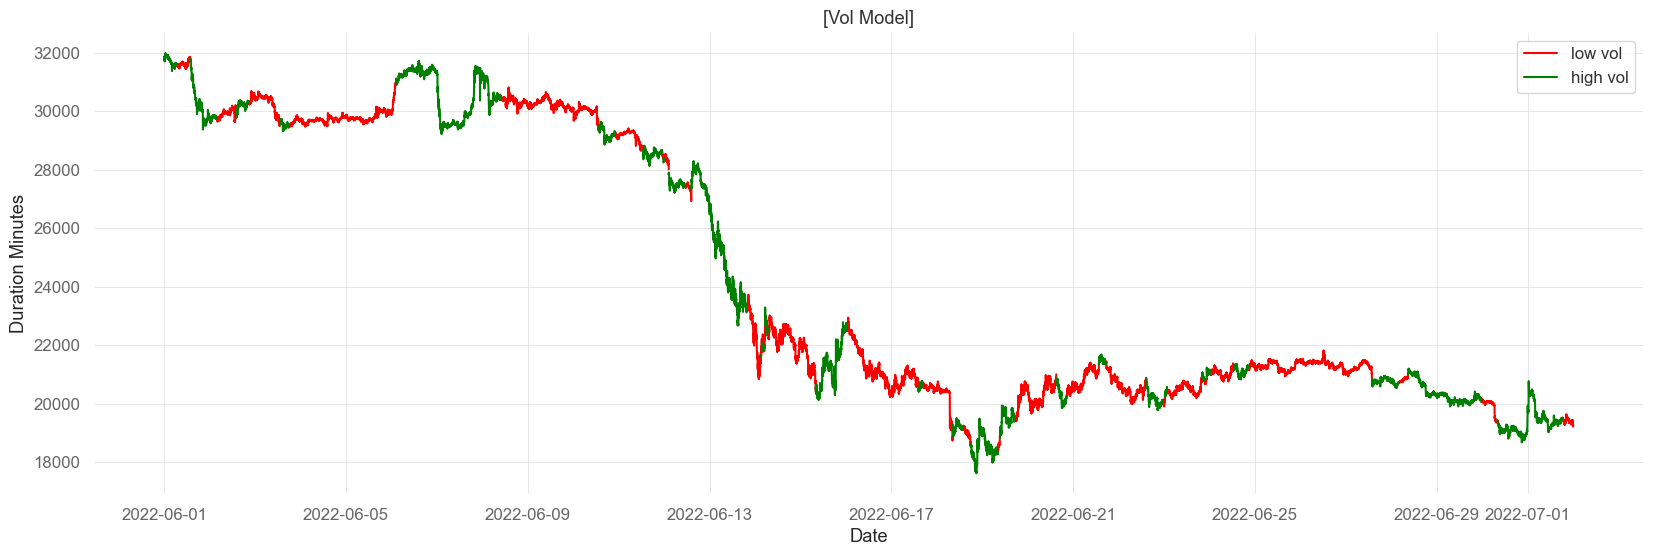

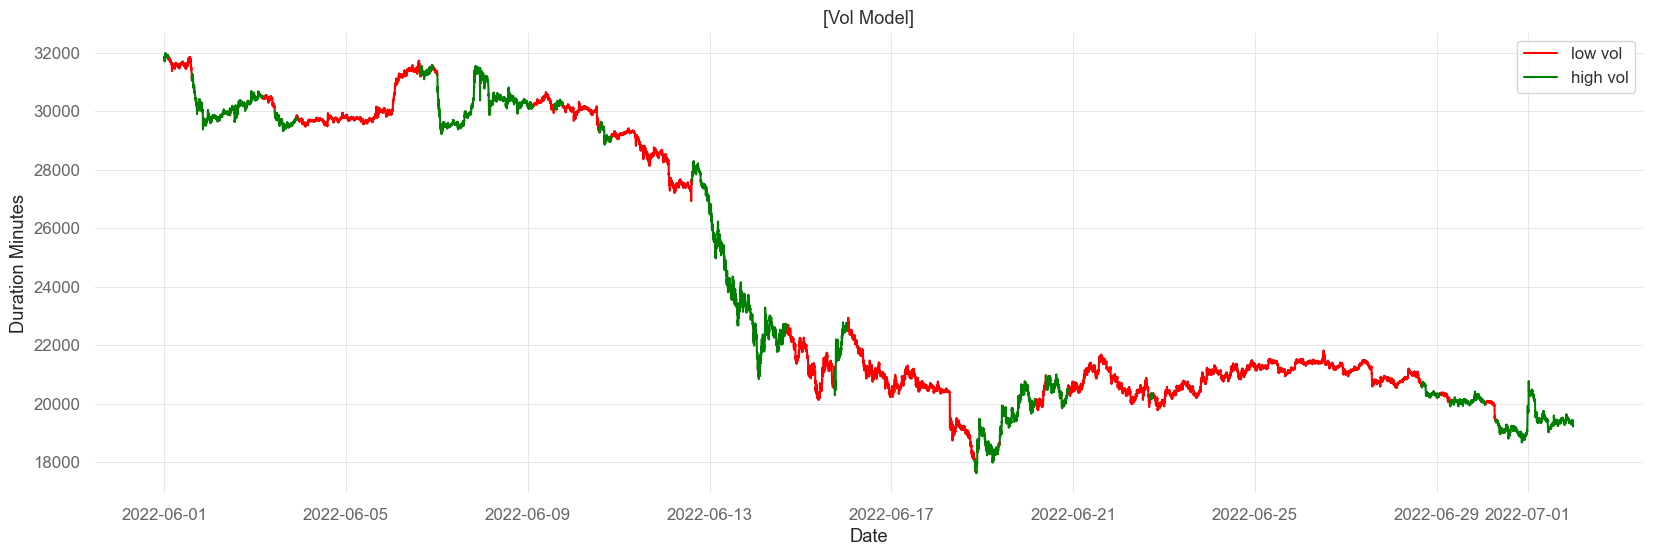

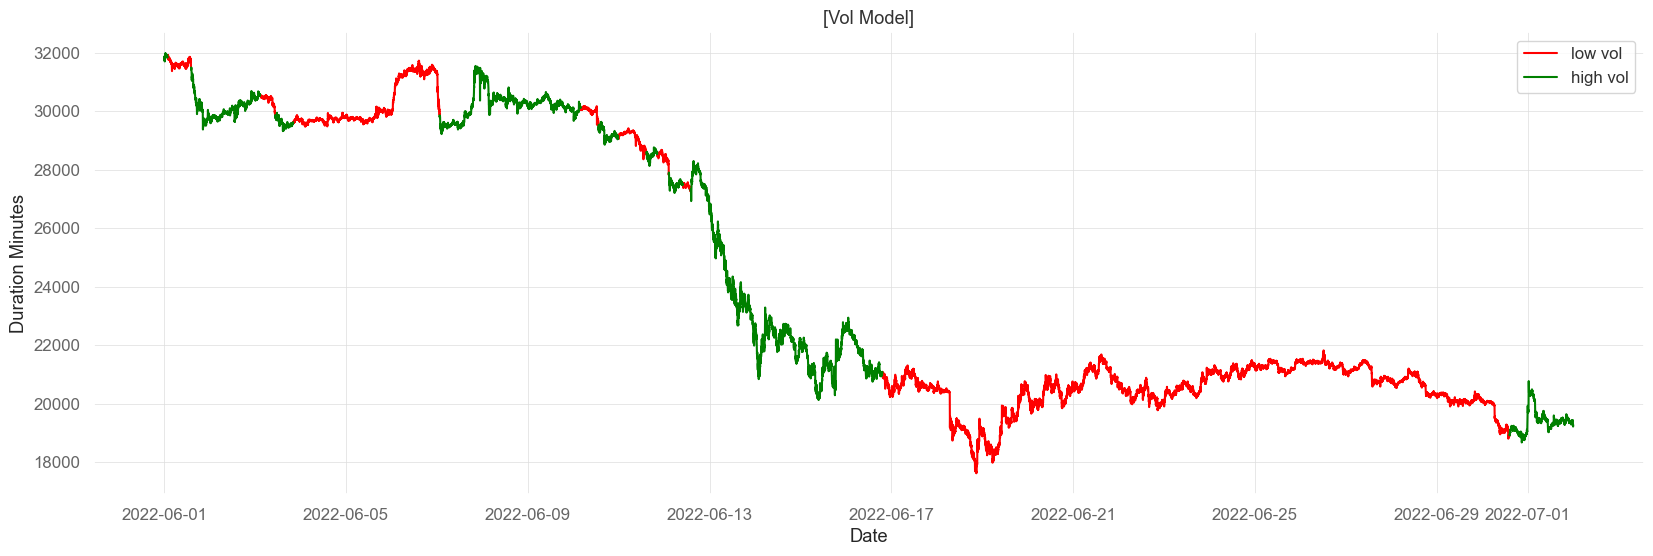

In [2]:
vol_model_90 = pd.read_csv("../../data/vol_models/BTCUSDT_90mill.csv")
vol_model_180 = pd.read_csv("../../data/vol_models/BTCUSDT_180mill.csv")
vol_model_360 = pd.read_csv("../../data/vol_models/BTCUSDT_360mill.csv")
vol_model_720 = pd.read_csv("../../data/vol_models/BTCUSDT_720mill.csv")


vol_models = [vol_model_90, vol_model_180, vol_model_360, vol_model_720]
# print(vol_model_90)
start = '2022-06-01'
end = '2022-07-01'

for vol_model in vol_models:
    vol_model = vol_model.dropna().copy()
    vol_model['Open Time'] = pd.to_datetime(vol_model['Open Time'])
    vol_model = vol_model.set_index('Open Time')
    
    
    
    plot_sample = vol_model.loc[start:end].copy()

    plot_sample['high vol'] = np.where(plot_sample['cross'] == 1, plot_sample['Close'], None)
    plot_sample['low vol'] = np.where(plot_sample['cross'] == -1, plot_sample['Close'], None)

    # Plot the Close, SMA, and EMA
    plt.figure(figsize=(20, 6))
    plt.plot(plot_sample.index, plot_sample['low vol'], label='low vol', color = 'red')
    plt.plot(plot_sample.index, plot_sample['high vol'], label='high vol', color = 'green')
    # plt.plot(plot_sample.index, plot_sample['Close'], label='close', linestyle='--', color = 'black')
    # plt.plot(plot_sample.index, plot_sample['sma'], label=f'SMA ({sma_window} periods)', linestyle='--', marker='o')
    # plt.plot(plot_sample.index, plot_sample['ema'], label=f'EMA (span={ema_span})', linestyle='--', marker='o')

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Duration Minutes')
    plt.title(f'[Vol Model]')
    plt.legend()
    # Display the plot
    plt.show()


In [51]:
"""
Lets do position manager entry style. And you enter in a red period, exit when it turns green 
You enter long or short based off 20 period and 50 period SMA (on 4 hour candles) 4800 min and 12000
Lets start with regular position manager 80 bps down and then add 1/6 1/3 1/2 or maybe we do less initial 
Next step could be changing the 80 bps to something market determined
"""
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

class PMvol(Strategy):
    
    # TRADE_SIZES = {0: .5, 1: .166, 2: .4, 3: .99, 4:0}
    TRADE_SIZES = {0: .25, 1: .666, 2: .99, 3: .99, 4:0}

    TP= .003
    ADD_THRESH = -.006
    MAX_TRADES = 3
    n1 = 20*60*4
    n2 = 50*60*4
    
    def _signal(self):
        return self.data.Signal
    
    def _vol(self):
        return self.data.cross
    
    def init(self):
        super().init()
        # self.signal = self.I(self._signal)
        self.vol = self.I(self._vol)

        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def bars_since_first_trade(self):
        if len(self.trades) > 0:
            first_trade_entry_bar = self.trades[0].entry_bar
            bars_since_first_trade = len(self.data.Close) - first_trade_entry_bar
            return bars_since_first_trade
        else:
            return 0
    
    def create_trailing_tp(self, action, size, trailing_tp_pct, tp_pct):
        direction = None
        # first execute initial trade
        if action == "buy":
            self.buy(size=size)
            direction = "long"
        elif action == "sell":
            self.sell(size=size)
            direction = "short"

        self.trailing_tp = {
            "order_status": "just_created",
            "direction": direction,
            "entry_price": None,
            "floor_ceiling_price": None,
            "num_orders": 1,
            "trailing_tp_pct": trailing_tp_pct,
            "tp_pct": tp_pct,
        }

    def initialize_tp(self):
        total_size = 0
        total_value = 0
        # get average trade price
        for trade in self.trades:
            # print(f'Past Trade {trade.size} {trade.value}')
            total_size += abs(trade.size)
            total_value += abs(trade.size) * trade.entry_price

        average_price = total_value / total_size

        self.trailing_tp["entry_price"] = average_price
        self.trailing_tp["order_status"] = "happening"

    def maintain_trailing_tp(self):
        
        if self.trailing_tp["order_status"] == "happening":
            
            if self.position.pl_pct > self.trailing_tp["tp_pct"]:
                
                # put in floor order
                if self.trailing_tp["direction"] == "long":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()
                    potential_new_floor_price = self.data.Close * (
                        1 - self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        floor_price = potential_new_floor_price
                    else:
                        floor_price = max(
                            potential_new_floor_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.sell(size=self.position.size, stop=floor_price)
                    self.trailing_tp["num_orders"] += 1

                if self.trailing_tp["direction"] == "short":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()

                    potential_new_ceiling_price = self.data.Close * (
                        1 + self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        ceiling_price = potential_new_ceiling_price
                    else:
                        ceiling_price = min(
                            potential_new_ceiling_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.buy(size=abs(self.position.size), stop=ceiling_price)
                    self.trailing_tp["num_orders"] += 1
    
    def set_signal(self):
        self.latest_signal_time = self.data.index[-1]
        self.latest_signal = self.signal

    def next(self):
        super().next()

        if not self.position:

            if self.vol[-1] == -1:
                if self.sma1 > self.sma2:
                    self.buy(size=self.TRADE_SIZES[0])
                else:
                    self.sell(size=self.TRADE_SIZES[0])
        
        if self.position:
            # print(f'Last Trade {self.trades[-1].pl_pct} Add Thresh {self.ADD_THRESH}')
            if self.vol[-1] == 1:
                self.position.close()
            
            elif self.position.is_long and self.sma1[-1] < self.sma2[-1]:
                # print(f'Cross {round(self.position.pl_pct, 4)}')
                self.position.close()
            elif self.position.is_short and self.sma1[-1] > self.sma2[-1]:
                # print(f'Cross {round(self.position.pl_pct, 4)}')
                self.position.close()
            
            
            elif self.trades[-1].pl_pct < self.ADD_THRESH and len(self.trades) < self.MAX_TRADES:

                if self.position.is_long:
                    self.buy(size=self.TRADE_SIZES[len(self.trades)])
                else:
                    self.sell(size=self.TRADE_SIZES[len(self.trades)])
            
            elif self.trades[-1].pl_pct < self.ADD_THRESH and len(self.trades) == self.MAX_TRADES:
                print(f'new stop loss {self.position.pl_pct*self.LEVERAGE_STATS[len(self.trades)]}')
                self.position.close()
            
            elif self.position.pl_pct > self.TP:
                self.position.close()
    
        

bt_start = '2022-01-01'
bt_end = '2023-12-01'

bt_data = vol_models[0].copy()
bt_data['Open Time'] = pd.to_datetime(bt_data['Open Time'])
bt_data = bt_data.set_index('Open Time')

# print(bt_data.loc[bt_start:bt_end])
bt = Backtest(
    bt_data.loc[bt_start:bt_end],
    PMvol,
    cash=100_000_000,
    trade_on_close=False,
    commission=0.0000,
    exclusive_orders=False,
    margin=.5,  # Set this to 0.5 for 2x leverage, 0.25 for 4x leverage, 0.125 for 8x leverage, etc.
)

stat = bt.run()
print(stat)

cleaned_trades = data_helpers.calc_acc_stats(stat['_trades'], 100_000_000)

# print(stat['_trades'].to_markdown())

# Plot the Close, SMA, and EMA
eq_curve = stat['_equity_curve'] / 1000000



# print(eq_curve.loc[].to_markdown())

plot_sample = eq_curve.loc[bt_start:bt_end].copy()
plot_sample_btc = bt_data.loc[bt_start:bt_end].copy()

plot_sample_btc['Normalized Price'] = plot_sample_btc['Close'] / plot_sample_btc['Close'].iloc[0] * 100

plt.figure(figsize=(20, 6))
plt.plot(plot_sample.index, plot_sample['Equity'], label='Strategy', color = 'black')
plt.plot(plot_sample_btc.index, plot_sample_btc['Normalized Price'], label='BTC', color = 'purple')
# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Low Vol Martingale')
plt.legend()


AttributeError: 'PMvol' object has no attribute 'LEVERAGE_STATS'

In [29]:
#I want to look at the average red period. how many trades are in each period and what is going on when we are losing. 2022-07- 2022-08 is a good example of this
df = cleaned_trades.copy()

df['FirstEntryTime'] = pd.to_datetime(df['FirstEntryTime'])
df['ExitTime'] = pd.to_datetime(df['ExitTime'])

df = df.set_index('FirstEntryTime')

df_slice = df.loc['2022-07-01':'2022-08-01']
df_slice = df_slice[['ExitTime', 'TotalSize', 'RowCount', 'portfolio', 'adj pnl']]
losers = df_slice[df_slice['adj pnl'] < -.01]

print(losers.to_markdown())

| FirstEntryTime      | ExitTime            |   TotalSize |   RowCount |   portfolio |    adj pnl |
|:--------------------|:--------------------|------------:|-----------:|------------:|-----------:|
| 2022-07-01 11:24:00 | 2022-07-01 13:48:00 |      -16588 |          3 | 1.66685e+08 | -0.0207409 |
| 2022-07-03 09:10:00 | 2022-07-03 20:09:00 |      -17254 |          3 | 1.70762e+08 | -0.0394133 |
| 2022-07-04 03:21:00 | 2022-07-04 10:05:00 |      -12645 |          2 | 1.64217e+08 | -0.0124792 |
| 2022-07-06 03:14:00 | 2022-07-06 04:16:00 |      -12066 |          2 | 1.628e+08   | -0.0191566 |
| 2022-07-06 13:48:00 | 2022-07-07 14:37:00 |      -15372 |          3 | 1.61866e+08 | -0.05102   |
| 2022-07-08 07:34:00 | 2022-07-08 08:59:00 |       10603 |          2 | 1.53607e+08 | -0.0144759 |
| 2022-07-09 17:35:00 | 2022-07-10 14:47:00 |       14015 |          3 | 1.54231e+08 | -0.0751383 |
| 2022-07-12 04:26:00 | 2022-07-12 07:19:00 |       10797 |          2 | 1.43444e+08 | -0.014548  |


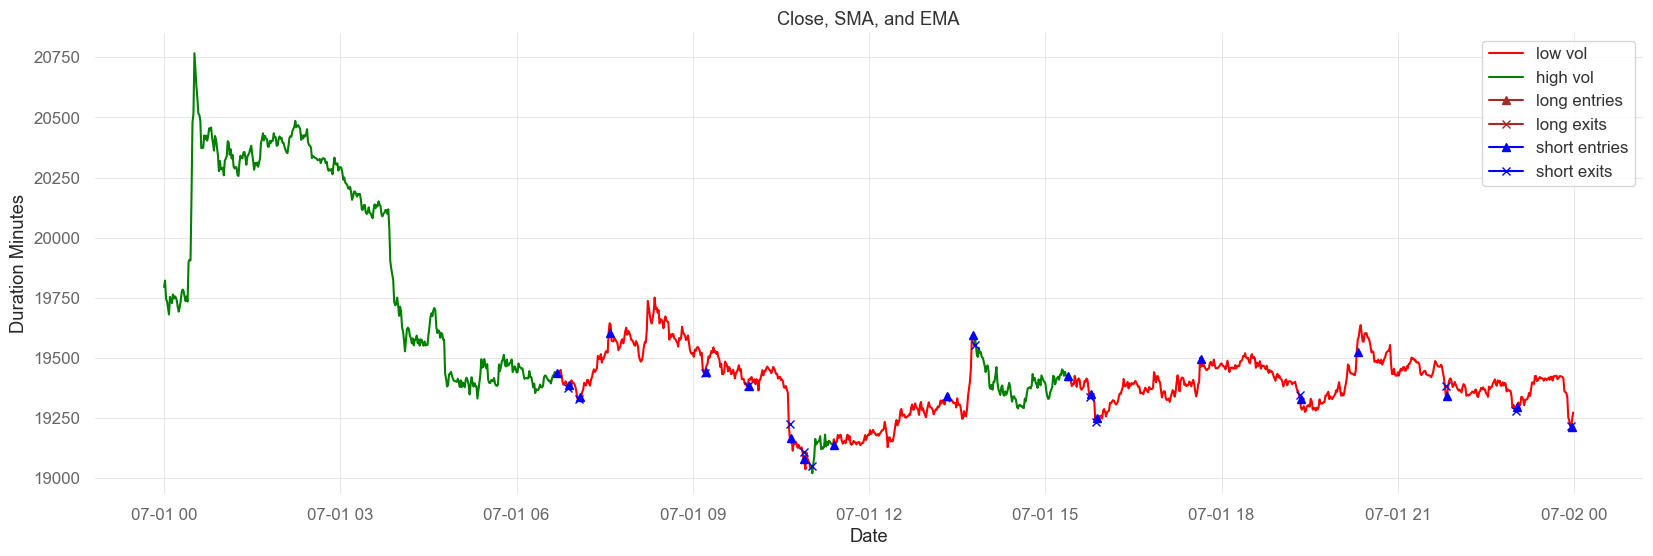

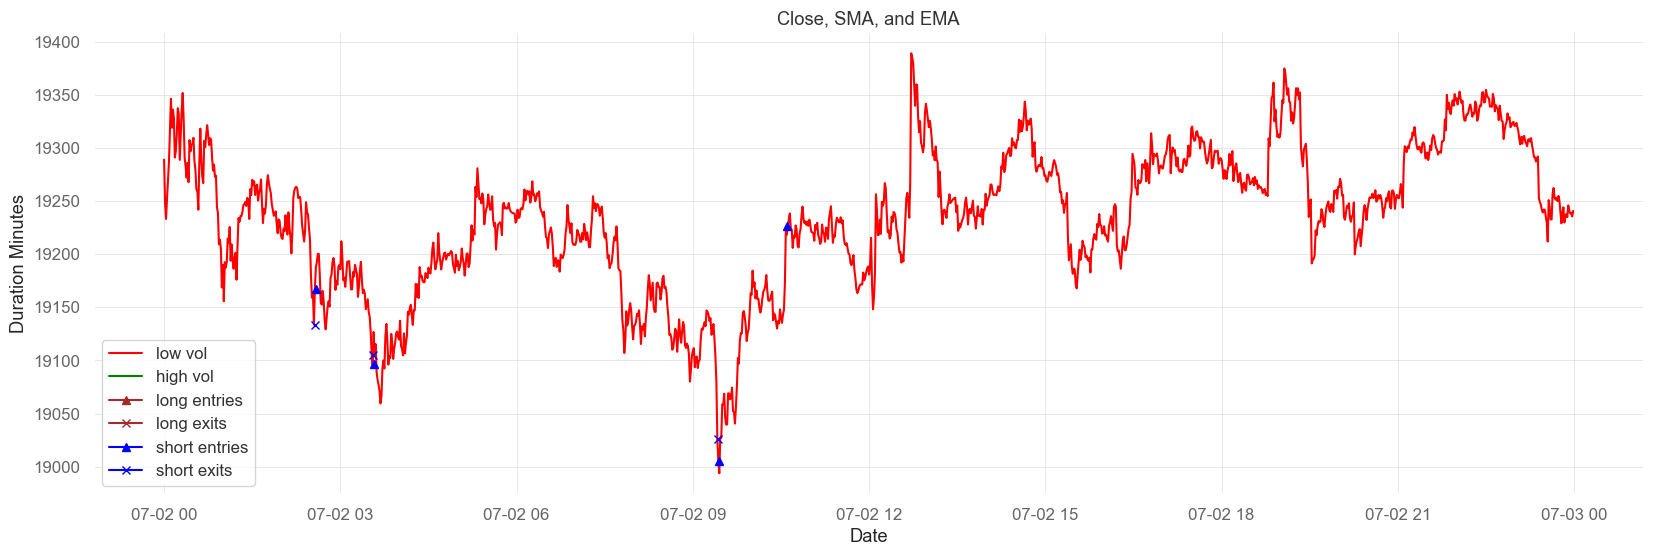

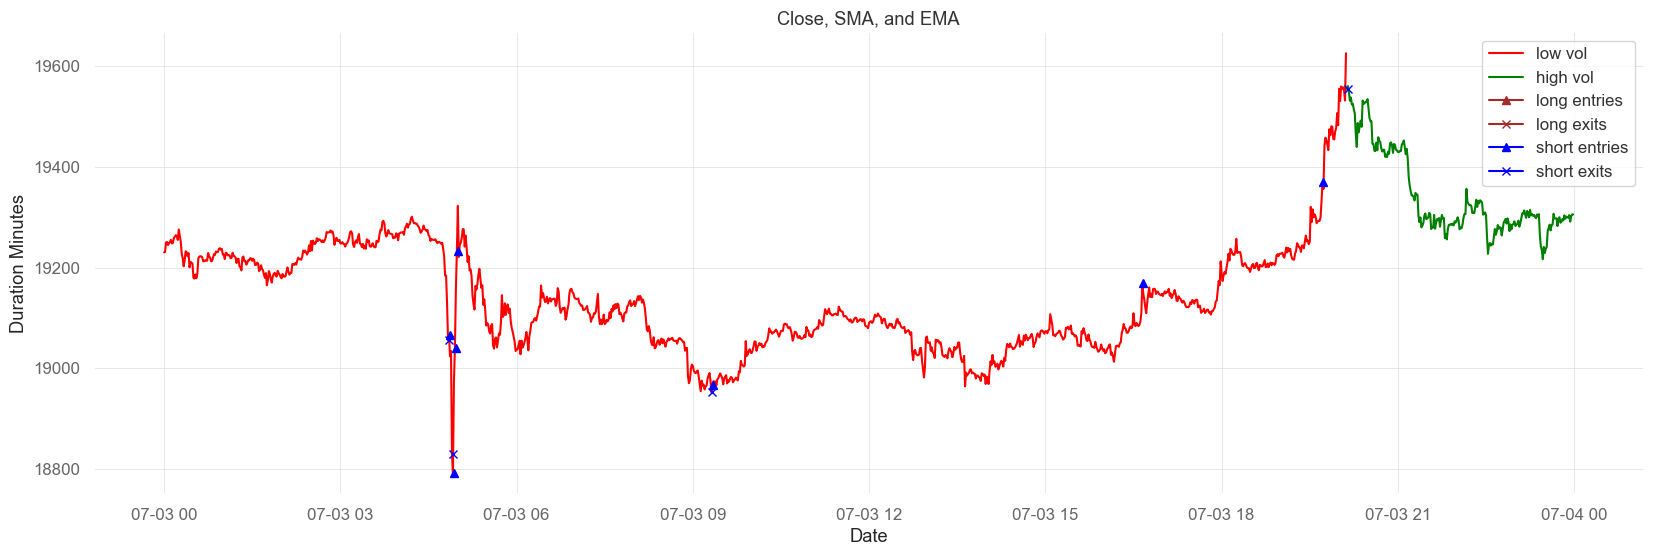

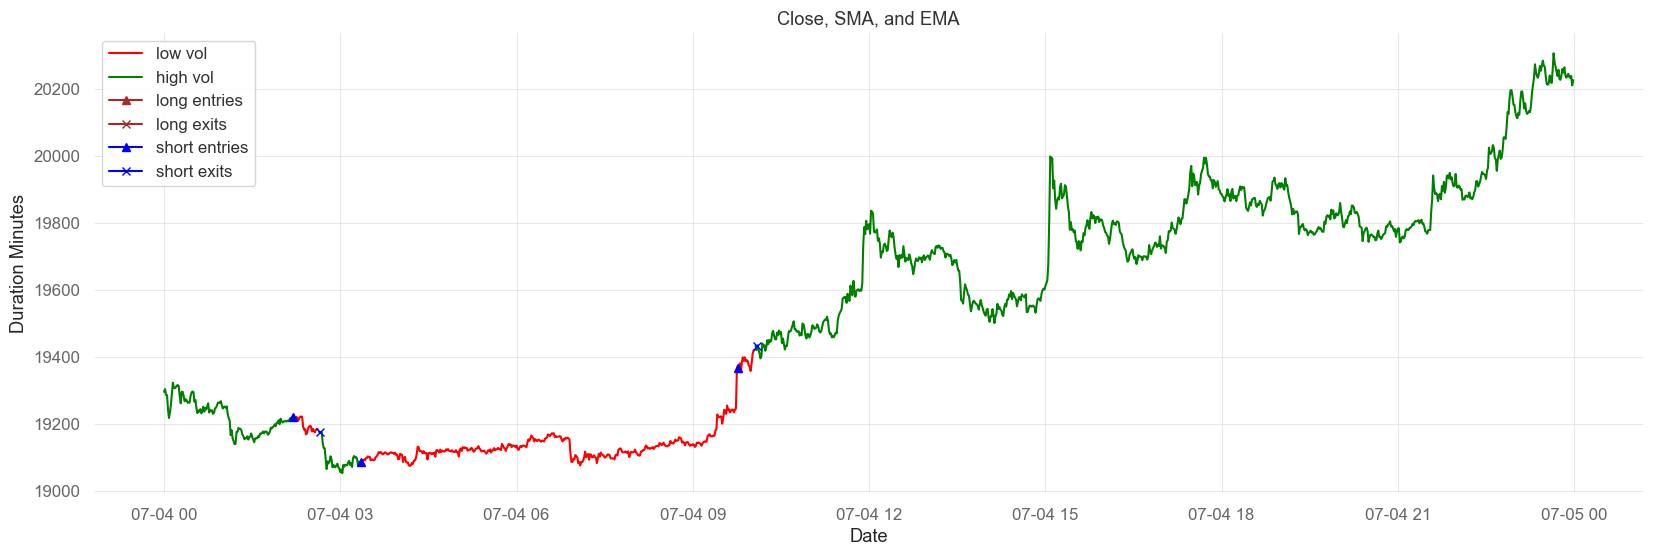

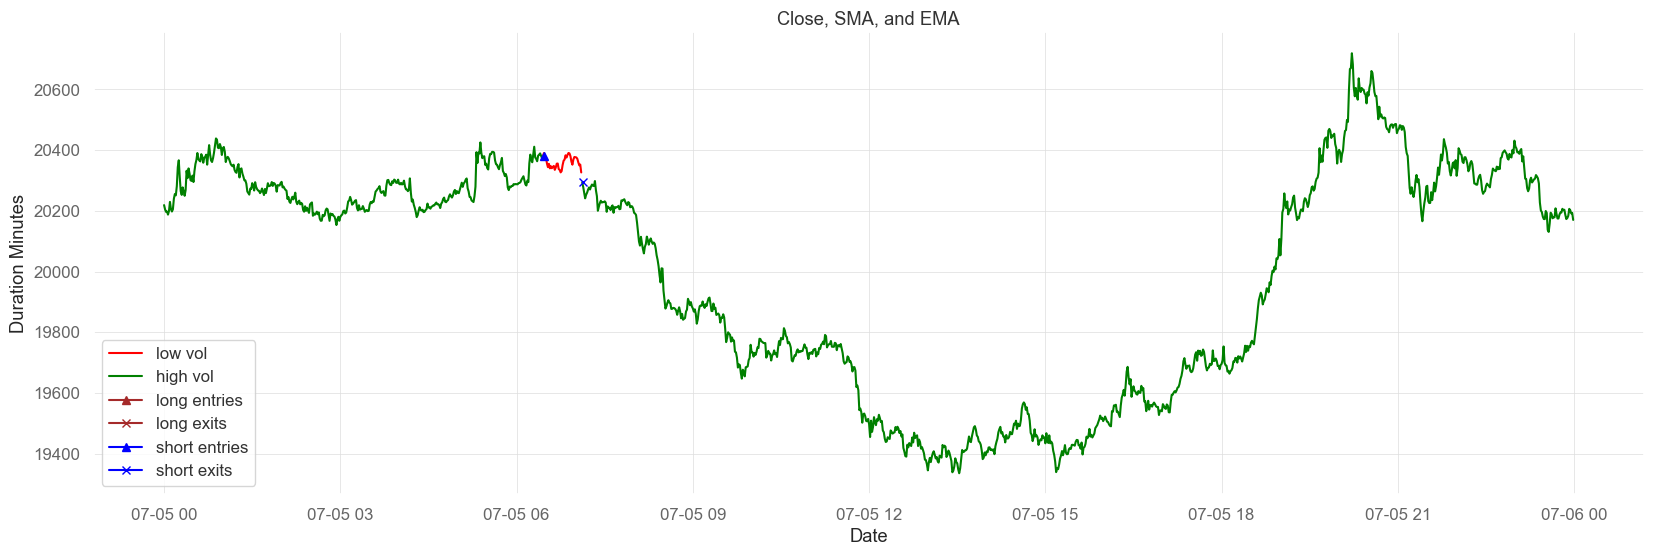

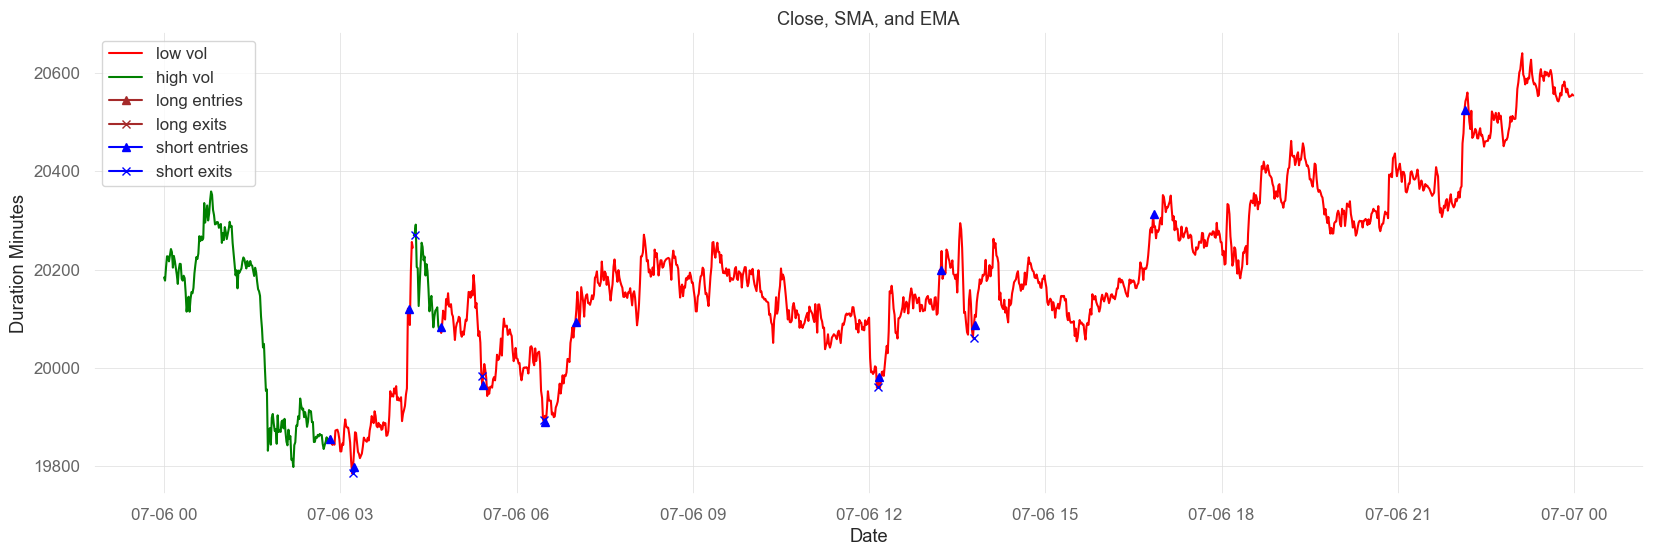

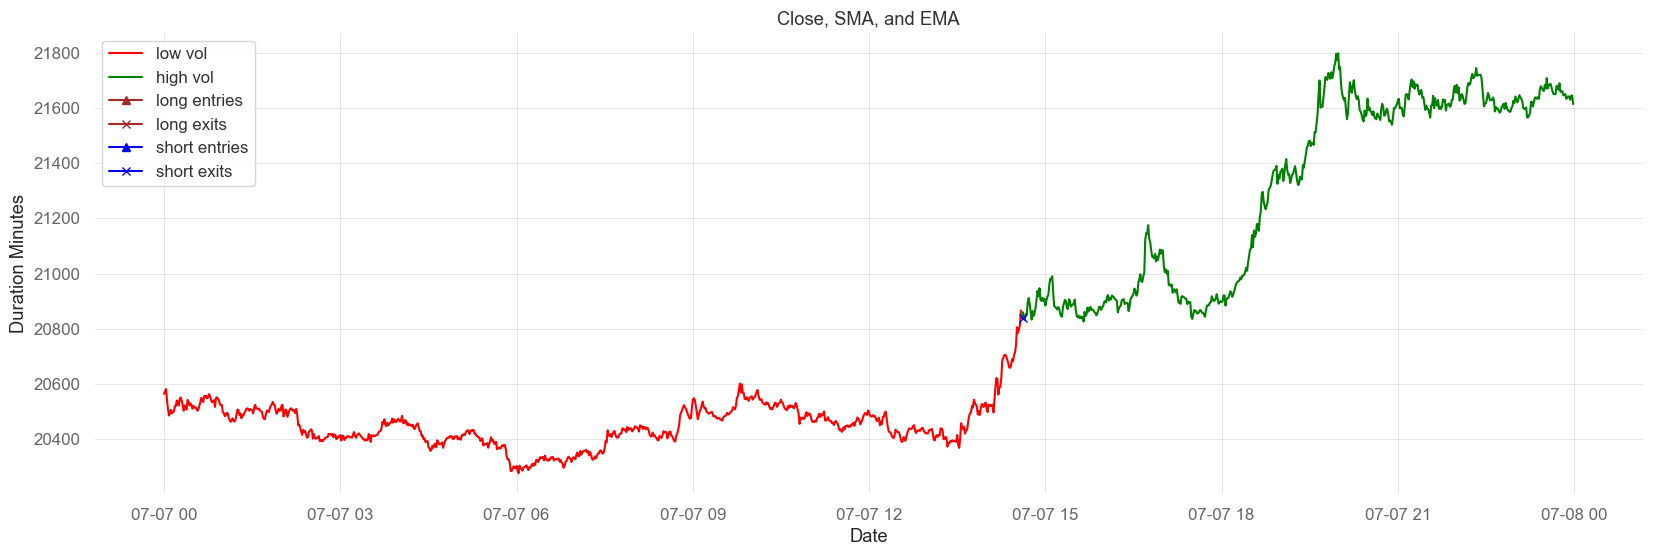

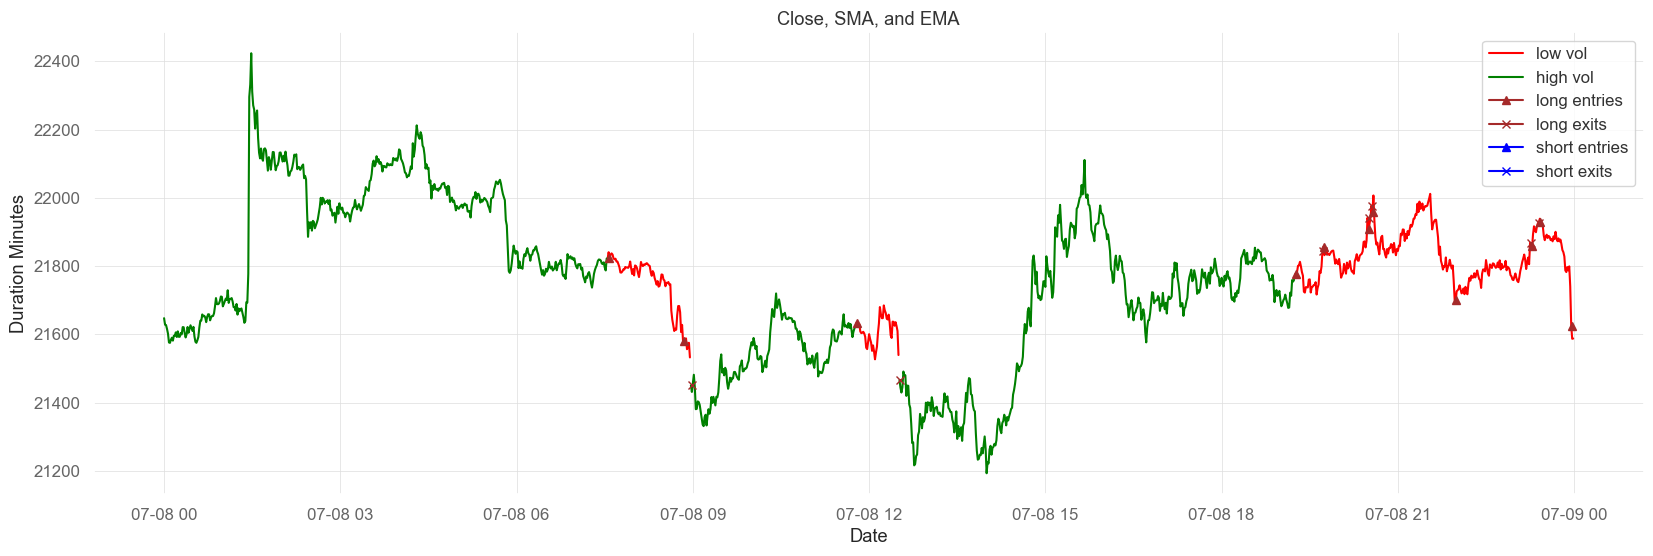

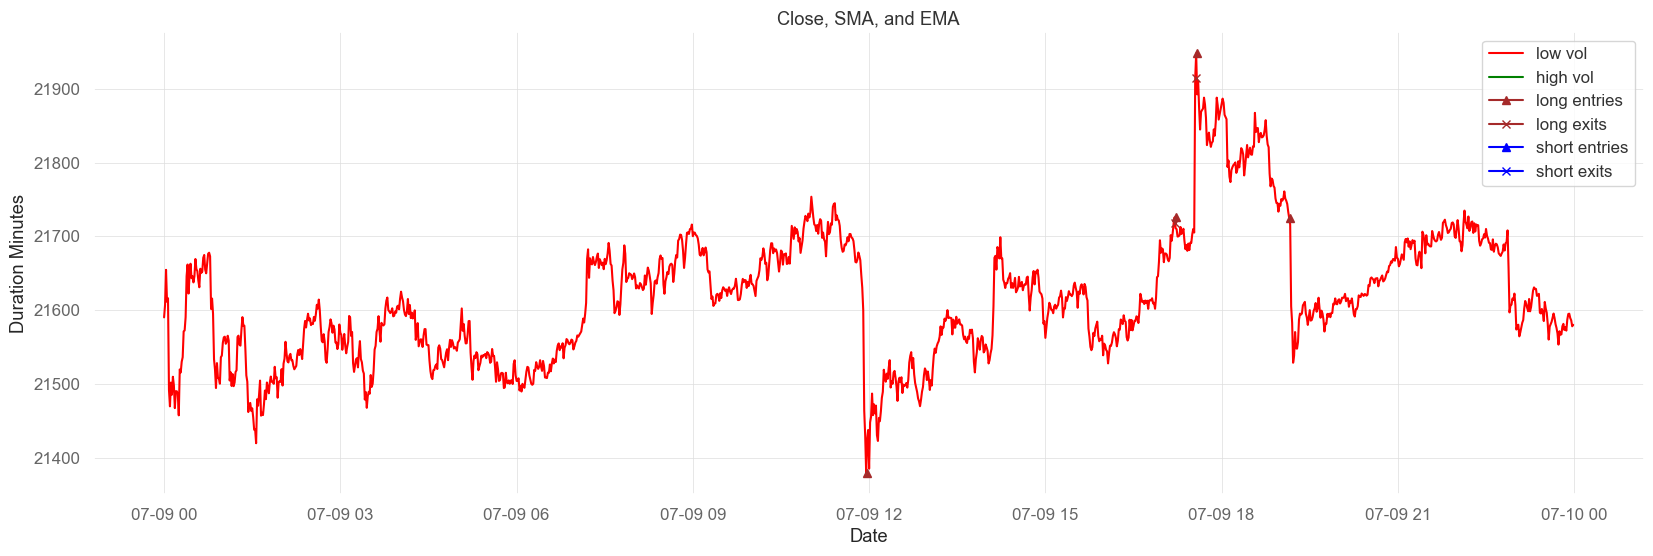

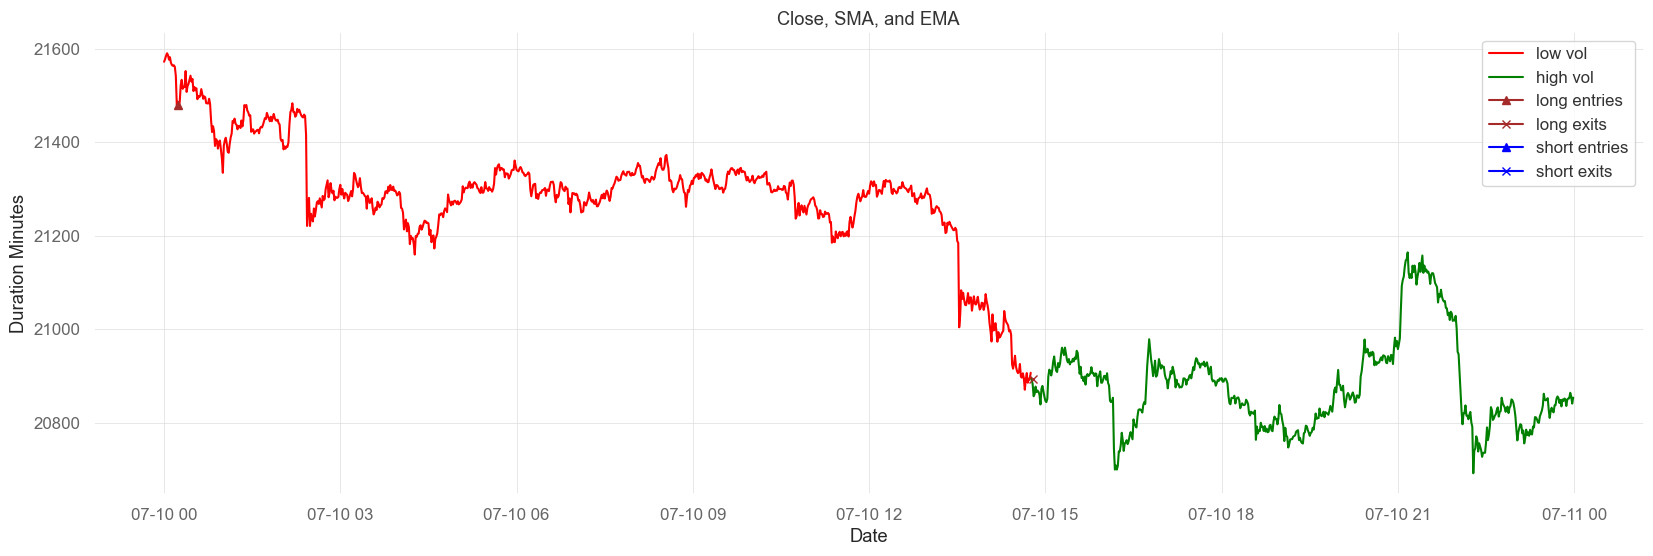

In [33]:
trade_analysis = bt_data.copy()
trade_analysis['long_entries'] = None
trade_analysis['long_exits'] = None
trade_analysis['short_entries'] = None
trade_analysis['short_exits'] = None

for index, row in stat['_trades'].iterrows():
    if row['Size'] > 0:
        trade_analysis.at[row['EntryTime'], 'long_entries'] = row['EntryPrice']
        trade_analysis.at[row['ExitTime'], 'long_exits'] = row['ExitPrice']
    if row['Size'] < 0:
        trade_analysis.at[row['EntryTime'], 'short_entries'] = row['EntryPrice']
        trade_analysis.at[row['ExitTime'], 'short_exits'] = row['ExitPrice']

num_days = 1
start_day = 1

for i in range(10):
    

    start = f'2022-7-{(i*num_days)+start_day}'
    end = f'2022-7-{(i+start_day)*num_days}'
    # start = f'2023-01-01'
    # end = f'2023-02-01'

    plot_sample = trade_analysis.loc[start:end].copy()

    # print(plot_sample.to_markdown())
    

    #red = -1
    # plot_sample['Normalized Price'] = plot_sample['Close'] / plot_sample['Close'].iloc[0] * 100
    plot_sample['low vol'] = np.where(plot_sample['cross'] == -1, plot_sample['Close'], None )
    plot_sample['high vol'] = np.where(plot_sample['cross'] == 1,  plot_sample['Close'], None)

    # plot_sample['psar buy'] = np.where(plot_sample['Signal'] != 1, None, plot_sample['Close'])
    # plot_sample['psar sell'] = np.where(plot_sample['Signal'] != -1, None, plot_sample['Close'])

    # print(plot_sample.to_markdown())

    # Plot the Close, SMA, and EMA
    plt.figure(figsize=(20, 6))
    plt.plot(plot_sample.index, plot_sample['low vol'], label='low vol', color = 'red')
    plt.plot(plot_sample.index, plot_sample['high vol'], label='high vol', color = 'green')
    # plt.plot(plot_sample.index, plot_sample['psar buy'], label = 'psar buy', marker = 'o', color = 'pink')
    # plt.plot(plot_sample.index, plot_sample['psar sell'], label = 'psar sell', marker = 'o', color = 'blue')
    plt.plot(plot_sample.index, plot_sample['long_entries'], label = 'long entries', marker = '^', color = 'brown')
    plt.plot(plot_sample.index, plot_sample['long_exits'], label = 'long exits', marker = 'x', color = 'brown')
    plt.plot(plot_sample.index, plot_sample['short_entries'], label = 'short entries', marker = '^', color = 'blue')
    plt.plot(plot_sample.index, plot_sample['short_exits'], label = 'short exits', marker = 'x', color = 'blue')
    # plt.plot(plot_sample.index, plot_sample['Close'], label='close', linestyle='--', color = 'black')
    # plt.plot(plot_sample.index, plot_sample['sma'], label=f'SMA ({sma_window} periods)', linestyle='--', marker='o')
    # plt.plot(plot_sample.index, plot_sample['ema'], label=f'EMA (span={ema_span})', linestyle='--', marker='o')

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Duration Minutes')
    plt.title('Close, SMA, and EMA')
    plt.legend()

In [ ]:
"""
THIS IS A GOOD PM
"""
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

class PMvol(Strategy):
    
    # TRADE_SIZES = {0: .5, 1: .166, 2: .4, 3: .99, 4:0}
    TRADE_SIZES = {0: .25, 1: .666, 2: .99, 3: .99, 4:0}

    TP= .002
    ADD_THRESH = -.006
    MAX_TRADES = 3
    n1 = 20*60*4
    n2 = 50*60*4
    
    def _signal(self):
        return self.data.Signal
    
    def _vol(self):
        return self.data.cross
    
    def init(self):
        super().init()
        # self.signal = self.I(self._signal)
        self.vol = self.I(self._vol)

        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def bars_since_first_trade(self):
        if len(self.trades) > 0:
            first_trade_entry_bar = self.trades[0].entry_bar
            bars_since_first_trade = len(self.data.Close) - first_trade_entry_bar
            return bars_since_first_trade
        else:
            return 0
    
    def create_trailing_tp(self, action, size, trailing_tp_pct, tp_pct):
        direction = None
        # first execute initial trade
        if action == "buy":
            self.buy(size=size)
            direction = "long"
        elif action == "sell":
            self.sell(size=size)
            direction = "short"

        self.trailing_tp = {
            "order_status": "just_created",
            "direction": direction,
            "entry_price": None,
            "floor_ceiling_price": None,
            "num_orders": 1,
            "trailing_tp_pct": trailing_tp_pct,
            "tp_pct": tp_pct,
        }

    def initialize_tp(self):
        total_size = 0
        total_value = 0
        # get average trade price
        for trade in self.trades:
            # print(f'Past Trade {trade.size} {trade.value}')
            total_size += abs(trade.size)
            total_value += abs(trade.size) * trade.entry_price

        average_price = total_value / total_size

        self.trailing_tp["entry_price"] = average_price
        self.trailing_tp["order_status"] = "happening"

    def maintain_trailing_tp(self):
        
        if self.trailing_tp["order_status"] == "happening":
            
            if self.position.pl_pct > self.trailing_tp["tp_pct"]:
                
                # put in floor order
                if self.trailing_tp["direction"] == "long":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()
                    potential_new_floor_price = self.data.Close * (
                        1 - self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        floor_price = potential_new_floor_price
                    else:
                        floor_price = max(
                            potential_new_floor_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.sell(size=self.position.size, stop=floor_price)
                    self.trailing_tp["num_orders"] += 1

                if self.trailing_tp["direction"] == "short":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()

                    potential_new_ceiling_price = self.data.Close * (
                        1 + self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        ceiling_price = potential_new_ceiling_price
                    else:
                        ceiling_price = min(
                            potential_new_ceiling_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.buy(size=abs(self.position.size), stop=ceiling_price)
                    self.trailing_tp["num_orders"] += 1
    
    def set_signal(self):
        self.latest_signal_time = self.data.index[-1]
        self.latest_signal = self.signal

    def next(self):
        super().next()

        if not self.position:

            if self.vol[-1] == -1:
                if self.sma1 > self.sma2:
                    self.buy(size=self.TRADE_SIZES[0])
                else:
                    self.sell(size=self.TRADE_SIZES[0])
        
        if self.position:
            # print(f'Last Trade {self.trades[-1].pl_pct} Add Thresh {self.ADD_THRESH}')
            if self.vol[-1] == 1:
                self.position.close()
            
            elif self.position.is_long and self.sma1 < self.sma2:
                print(f'Cross {round(self.position.pl_pct, 4)}')
                self.position.close()
            elif self.position.is_short and self.sma1 > self.sma2:
                print(f'Cross {round(self.position.pl_pct, 4)}')
                self.position.close()
            
            
            elif self.trades[-1].pl_pct < self.ADD_THRESH and len(self.trades) < self.MAX_TRADES:

                if self.position.is_long:
                    self.buy(size=self.TRADE_SIZES[len(self.trades)])
                else:
                    self.sell(size=self.TRADE_SIZES[len(self.trades)])
            
            elif self.position.pl_pct > self.TP:
                self.position.close()
    
        

bt_start = '2022-01-01'
bt_end = '2023-12-01'

bt_data = vol_models[0].copy()
bt_data['Open Time'] = pd.to_datetime(bt_data['Open Time'])
bt_data = bt_data.set_index('Open Time')

# print(bt_data.loc[bt_start:bt_end])
bt = Backtest(
    bt_data.loc[bt_start:bt_end],
    PMvol,
    cash=100_000_000,
    trade_on_close=False,
    commission=0.0000,
    exclusive_orders=False,
    margin=1,  # Set this to 0.5 for 2x leverage, 0.25 for 4x leverage, 0.125 for 8x leverage, etc.
)

stat = bt.run()
print(stat)

cleaned_trades = data_helpers.calc_acc_stats(stat['_trades'], 100_000_000)

# print(stat['_trades'].to_markdown())

# Plot the Close, SMA, and EMA
eq_curve = stat['_equity_curve'] / 1000000



# print(eq_curve.loc[].to_markdown())

plot_sample = eq_curve.loc[bt_start:bt_end].copy()
plot_sample_btc = bt_data.loc[bt_start:bt_end].copy()

plot_sample_btc['Normalized Price'] = plot_sample_btc['Close'] / plot_sample_btc['Close'].iloc[0] * 100

plt.figure(figsize=(20, 6))
plt.plot(plot_sample.index, plot_sample['Equity'], label='Equity', color = 'black')
plt.plot(plot_sample_btc.index, plot_sample_btc['Normalized Price'], label='BTC', color = 'purple')
# Set labels and title
plt.xlabel('Date')
plt.ylabel('Duration Minutes')
plt.title('Close, SMA, and EMA')
plt.legend()
